# Multimodal Text-to-Image Project (CPU-only) — Tasks 1–6

This notebook is a **CPU-first** implementation that integrates your local datasets and creates outputs under `submissions/task_<n>/`.

**Datasets (used here; change paths if needed)**:
- COCO: `D:\Projects\NullClass\Datasets\coco\coco2017`
- CelebA-MM: `D:\Projects\NullClass\Datasets\Artwork_Faces_ The Multi-Modal CelebA-HQ\MM-CELEBA-HQ`
- DeepFashion: `D:\Projects\NullClass\Datasets\DeepFashion-MultiModal`
- Oxford-102 Flowers: `D:\Projects\NullClass\Datasets\Oxford-102 Flowers\dataset`
- LAION: caption-only JSON (no images) — used only for text embeddings if desired.

**Warning:** Training SD/LoRA on CPU is extremely slow. Use tiny subsets and low steps (the examples default to very small values).

In [1]:
# Preflight checks (RUN FIRST)
import sys, platform, os, time
import torch
from pathlib import Path

print("Platform:", platform.platform())
print("Python:", sys.version.splitlines()[0])
print("Torch:", getattr(torch, '__version__', 'not found'))
print("CUDA available:", torch.cuda.is_available())
print("For this notebook we will FORCE CPU mode for all models (device=cpu).")

device = torch.device("cpu")

# create top-level submissions folder
BASE = Path.cwd() / "submissions"
BASE.mkdir(exist_ok=True)
print("All outputs will be written under:", BASE.resolve())

print("\nRecommended packages (install before heavy tasks):")
print("pip install torch torchvision transformers diffusers datasets safetensors peft pillow tqdm")
print("If you have GPU later, consider xformers and accelerate.")

Platform: Windows-10-10.0.26100-SP0
Python: 3.9.0 (tags/v3.9.0:9cf6752, Oct  5 2020, 15:34:40) [MSC v.1927 64 bit (AMD64)]
Torch: 2.8.0+cpu
CUDA available: False
For this notebook we will FORCE CPU mode for all models (device=cpu).
All outputs will be written under: D:\Projects\submissions

Recommended packages (install before heavy tasks):
pip install torch torchvision transformers diffusers datasets safetensors peft pillow tqdm
If you have GPU later, consider xformers and accelerate.


## Utilities & directories
Functions to manage task folders and save JSON logs.

In [2]:
# Utilities for tasks
import json, shutil

def ensure_task_dir(n:int):
    p = BASE / f"task_{n}"
    p.mkdir(parents=True, exist_ok=True)
    (p / "models").mkdir(exist_ok=True)
    (p / "outputs").mkdir(exist_ok=True)
    (p / "logs").mkdir(exist_ok=True)
    return p

def save_json(obj, p:Path):
    with open(p, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2)

## Dataset loaders (Task 4 helpers)
Loaders for COCO, CelebA-MM, DeepFashion, Oxford-102, and LAION captions-only.
These return `ImageCaptionDataset` for SD/embeddings and `SimpleImageDataset` for CGAN.

In [3]:
# Dataset loaders integrated with your paths
import os, json, pandas as pd
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

IMAGE_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def list_images(folder):
    p = Path(folder)
    if not p.exists():
        return []
    return [str(fp) for fp in p.rglob("*") if fp.suffix.lower() in IMAGE_EXT]

class ImageCaptionDataset(Dataset):
    def __init__(self, image_paths, captions, resolution=512):
        assert len(image_paths) == len(captions)
        self.image_paths = image_paths
        self.captions = captions
        self.res = resolution
        self.transform = transforms.Compose([
            transforms.Resize((resolution, resolution)),
            transforms.CenterCrop(resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        return self.transform(img), str(self.captions[idx])

class SimpleImageDataset(Dataset):
    def __init__(self, image_paths, resolution=64):
        self.image_paths = image_paths
        self.res = resolution
        self.transform = transforms.Compose([
            transforms.Resize((resolution, resolution)),
            transforms.CenterCrop(resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        return self.transform(img), 0

# ---- dataset loader functions (paths default to your provided folders) ----

def load_coco(coco_root=r"D:\\Projects\\NullClass\\Datasets\\coco\\coco2017", limit=None):
    ann = Path(coco_root) / "annotations" / "captions_train2017.json"
    imgfolder = Path(coco_root) / "train2017"
    if not ann.exists():
        print("COCO annotations not found:", ann); return None
    with open(ann, "r", encoding="utf-8") as f:
        data = json.load(f)
    caption_map = {}
    for a in data["annotations"]:
        caption_map.setdefault(a["image_id"], []).append(a["caption"])
    imgs, caps = [], []
    for item in data["images"]:
        p = imgfolder / item["file_name"]
        if p.exists():
            imgs.append(str(p))
            caps.append(caption_map.get(item["id"], [""])[0])
            if limit and len(imgs) >= limit: break
    print(f"Loaded COCO images: {len(imgs)}")
    return ImageCaptionDataset(imgs, caps)

def load_celeba(root=r"D:\\Projects\\NullClass\\Datasets\\Artwork_Faces_ The Multi-Modal CelebA-HQ\\MM-CELEBA-HQ", limit=None):
    images_dir = Path(root) / "images"
    captions_file = Path(root) / "celeba-caption" / "captions.txt"
    imgs = list_images(images_dir)
    caps = []
    if captions_file.exists():
        with open(captions_file, "r", encoding="utf-8") as f:
            caps = [l.strip() for l in f if l.strip()]
    if not caps:
        caps = ["a portrait photo"] * len(imgs)
    else:
        if len(caps) < len(imgs):
            caps = caps + ["a portrait photo"]*(len(imgs)-len(caps))
    if limit:
        imgs = imgs[:limit]; caps = caps[:limit]
    print(f"Loaded CelebA images: {len(imgs)}")
    return ImageCaptionDataset(imgs, caps)

def load_deepfashion(root=r"D:\\Projects\\NullClass\\Datasets\\DeepFashion-MultiModal", limit=None):
    images_dir = Path(root) / "selected_images"
    imgs = [str(fp) for fp in images_dir.rglob("*") if fp.suffix.lower() in IMAGE_EXT]  # Ensured .jpg, .png etc.
    
    if not imgs:
        print(f"No images found in {images_dir}. Check folder or extensions.")
        return None

    # Try to load descriptions from csv or feather if available
    captions = ["a fashion image"] * len(imgs)
    csvf = Path(root) / "labels_front.csv"
    featherf = Path(root) / "labels_front.feather"

    if csvf.exists():
        df = pd.read_csv(csvf)
        if 'image' in df.columns and 'description' in df.columns:
            m = dict(zip(df['image'].astype(str), df['description'].astype(str)))
            captions = [m.get(Path(p).name, "a fashion image") for p in imgs]
    elif featherf.exists():
        try:
            import pyarrow.feather as feather_mod
            df = feather_mod.read_feather(str(featherf))
            if 'image' in df.columns and 'description' in df.columns:
                m = dict(zip(df['image'].astype(str), df['description'].astype(str)))
                captions = [m.get(Path(p).name, "a fashion image") for p in imgs]
        except Exception:
            pass

    if limit:
        imgs = imgs[:limit]; captions = captions[:limit]

    print(f"Loaded DeepFashion images: {len(imgs)}")
    return ImageCaptionDataset(imgs, captions)

def load_oxford(root=r"D:\\Projects\\NullClass\\Datasets\\Oxford-102 Flowers\\dataset", limit=None):
    imgs = list_images(root)
    caps = ["a photo of a flower"]*len(imgs)
    if limit: imgs=imgs[:limit]; caps=caps[:limit]
    print(f"Loaded Oxford flowers images: {len(imgs)}")
    return ImageCaptionDataset(imgs, caps)

# LAION: caption-only loader (no image downloads)
def load_laion_captions(json_path=r"D:\\Projects\\NullClass\\Datasets\\laion 5b\\GUIE_laion5b_dataset_en.json", limit=2000):
    if not Path(json_path).exists():
        print("LAION json not found:", json_path)
        return None
    
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)  # Proper JSON load (NOT line-by-line)
    except json.JSONDecodeError:
        print("Invalid JSON format. Ensure it's not JSONL.")
        return None

    captions = []
    for item in data:
        cap = item.get("caption") or item.get("text") or item.get("description") or item.get("prompt") or ""
        if cap:
            captions.append(cap)
        if limit and len(captions) >= limit:
            break

    print(f"Loaded {len(captions)} LAION captions (text-only).")
    return captions if captions else None

### === TEST DATASET LOADERS ===

In [4]:
# Test COCO
print("\n---- Testing COCO ----")
coco_data = load_coco(limit=5)
print("Sample size:", len(coco_data) if coco_data else "None")
if coco_data:
    img, cap = coco_data[0]
    print("Sample caption:", cap)
    print("Image tensor shape:", img.shape)

# Test CelebA-HQ
print("\n---- Testing CelebA ----")
celeba_data = load_celeba(limit=5)
print("Sample size:", len(celeba_data) if celeba_data else "None")
if celeba_data:
    img, cap = celeba_data[0]
    print("Sample caption:", cap)
    print("Image tensor shape:", img.shape)

# Test DeepFashion
print("\n---- Testing DeepFashion ----")
fashion_data = load_deepfashion(limit=5)
print("Sample size:", len(fashion_data) if fashion_data else "None")
if fashion_data:
    img, cap = fashion_data[0]
    print("Sample caption:", cap)
    print("Image tensor shape:", img.shape)

# Test Oxford Flowers
print("\n---- Testing Oxford Flowers ----")
oxford_data = load_oxford(limit=5)
print("Sample size:", len(oxford_data) if oxford_data else "None")
if oxford_data:
    img, cap = oxford_data[0]
    print("Sample caption:", cap)
    print("Image tensor shape:", img.shape)

# Test LAION captions-only
print("\n---- Testing LAION Captions ----")
laion_caps = load_laion_captions(limit=5)
print("Sample captions:", laion_caps[:5] if laion_caps else "None")


---- Testing COCO ----
Loaded COCO images: 5
Sample size: 5
Sample caption: A man with a red helmet on a small moped on a dirt road. 
Image tensor shape: torch.Size([3, 512, 512])

---- Testing CelebA ----
Loaded CelebA images: 5
Sample size: 5
Sample caption: a portrait photo
Image tensor shape: torch.Size([3, 512, 512])

---- Testing DeepFashion ----
Loaded DeepFashion images: 5
Sample size: 5
Sample caption: a fashion image
Image tensor shape: torch.Size([3, 512, 512])

---- Testing Oxford Flowers ----
Loaded Oxford flowers images: 5
Sample size: 5
Sample caption: a photo of a flower
Image tensor shape: torch.Size([3, 512, 512])

---- Testing LAION Captions ----
Loaded 5 LAION captions (text-only).
Sample captions: ['gladiatore', 'Gladiator is listed (or ranked) 4 on the list These Are The Most Historically Inaccurate Movies Of All Time', 'are-you-not-entertained-w-text-720x396', '"Russell Crowe em ""Gladiador"" - ©Dreamworks/Universal/The Kobal  Collection/Jaap Buitendijk"', 'Port

## Task 1 — Dataset inspection & stats
Load each dataset, print counts, show a few sample images and captions.

In [5]:
# Inspect datasets and save a few sample images per dataset
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

def save_samples_from_dataset(dataset, task_dir:Path, max_samples=5):
    task_dir.mkdir(parents=True, exist_ok=True)
    saved = 0
    for i in range(min(len(dataset), max_samples)):
        img_tensor, caption = dataset[i]
        # convert tensor to numpy image
        img = ((img_tensor.permute(1,2,0).numpy() * 0.5) + 0.5).clip(0,1)
        out_path = task_dir / "outputs" / f"sample_{i+1}.png"
        plt.imsave(out_path, img)
        with open(task_dir / "outputs" / f"sample_{i+1}_caption.txt", "w", encoding="utf-8") as f:
            f.write(str(caption))
        saved += 1
    print(f"Saved {saved} samples to {task_dir / 'outputs'}")
    return saved

# Example: Inspect a small subset of each dataset (use limit to keep small)
task_dir = ensure_task_dir(4)
coco_ds = load_coco(limit=8)
if coco_ds:
    save_samples_from_dataset(coco_ds, ensure_task_dir(4), max_samples=3)
celeba_ds = load_celeba(limit=8)
if celeba_ds:
    save_samples_from_dataset(celeba_ds, ensure_task_dir(4), max_samples=3)
df_ds = load_deepfashion(limit=8)
if df_ds:
    save_samples_from_dataset(df_ds, ensure_task_dir(4), max_samples=3)
ox_ds = load_oxford(limit=8)
if ox_ds:
    save_samples_from_dataset(ox_ds, ensure_task_dir(4), max_samples=3)

Loaded COCO images: 8
Saved 3 samples to D:\Projects\submissions\task_4\outputs
Loaded CelebA images: 8
Saved 3 samples to D:\Projects\submissions\task_4\outputs
Loaded DeepFashion images: 8
Saved 3 samples to D:\Projects\submissions\task_4\outputs
Loaded Oxford flowers images: 8
Saved 3 samples to D:\Projects\submissions\task_4\outputs


## Task 5 — Text embeddings (CLIP) for captions (CPU)
This builds CLIP text embeddings for a dataset captions (CPU). Use small batch size.

In [6]:
# CLIP embeddings (CPU)
from transformers import CLIPTokenizer, CLIPTextModel
import torch
device = torch.device("cpu")

def build_clip_embeddings_for_dataset(dataset: ImageCaptionDataset, task_dir:Path, model_name="openai/clip-vit-base-patch32", batch_size=8):
    task_dir.mkdir(parents=True, exist_ok=True)
    print("Loading tokenizer & text model (CPU). This will download model weights if missing.")

    tokenizer = CLIPTokenizer.from_pretrained(model_name)
    text_encoder = CLIPTextModel.from_pretrained(model_name)
    text_encoder = text_encoder.to(device)  # CPU

    captions = [dataset[i][1] for i in range(len(dataset))]
    embeddings = []

    for i in range(0, len(captions), batch_size):
        batch = captions[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")

        with torch.no_grad():   # torch now correctly refers to global torch
            out = text_encoder(**enc)
            pooled = out.last_hidden_state.mean(dim=1)
            embeddings.append(pooled.cpu())

    # FIX: No local import
    if embeddings:
        embs = torch.cat(embeddings, dim=0)
    else:
        embs = torch.empty((0, 768))  # <-- no `import torch` here

    out_path = task_dir / "outputs" / "clip_text_embeddings.pt"
    out_path.parent.mkdir(parents=True, exist_ok=True)
    torch.save({"captions": captions, "embeddings": embs}, out_path)

    print("Saved CLIP embeddings to", out_path)
    return out_path

In [7]:
from pathlib import Path

# 1. Load any dataset (example: COCO)
ds_coco = load_coco(limit=5)   # Use 5 samples for quick CPU test

# 2. Set directory where embeddings and outputs should be saved
task1_dir = Path("D:/Projects/NullClass/Task1_Embeddings")
task1_dir.mkdir(parents=True, exist_ok=True)

# 3. Explicitly call the embedding builder
clip_embed_path = build_clip_embeddings_for_dataset(ds_coco, task1_dir)

# 4. Print confirmation and sample embedding size
data_loaded = torch.load(clip_embed_path)
print("\nSaved File:", clip_embed_path)
print("Captions Loaded:", len(data_loaded["captions"]))
print("Embedding Tensor Shape:", data_loaded["embeddings"].shape)
print("Done.")

Loaded COCO images: 5
Loading tokenizer & text model (CPU). This will download model weights if missing.
Saved CLIP embeddings to D:\Projects\NullClass\Task1_Embeddings\outputs\clip_text_embeddings.pt

Saved File: D:\Projects\NullClass\Task1_Embeddings\outputs\clip_text_embeddings.pt
Captions Loaded: 5
Embedding Tensor Shape: torch.Size([5, 512])
Done.


## Task 2 — Attention strategies summary
Short notes and implementation used (self-attention in CGAN and how cross-attention works in diffusion U-Net).

In [8]:
print("""
Attention summary:
- Self-attention inside GAN generator helps relate distant spatial regions.
- Cross-attention in diffusion U-Net is how text embeddings condition image generation.
- We included a small SelfAttention block used in the CGAN generator (below).
""")


Attention summary:
- Self-attention inside GAN generator helps relate distant spatial regions.
- Cross-attention in diffusion U-Net is how text embeddings condition image generation.
- We included a small SelfAttention block used in the CGAN generator (below).



## Task 1 & 6 — CGAN + Self-Attention (CPU-safe)
Small CGAN training function (designed for tiny CPU runs). Use a small dataset limit (<=64 images) and a few epochs.

In [29]:
# CGAN with Self-Attention (CPU) — FINAL FIXED VERSION
import torch
import torch.nn as nn
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from pathlib import Path
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

# ─────────────────────────────────────────────
# Self-Attention Block
# ─────────────────────────────────────────────
class SelfAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.to_q = nn.Conv2d(dim, dim, 1)
        self.to_k = nn.Conv2d(dim, dim, 1)
        self.to_v = nn.Conv2d(dim, dim, 1)
        self.proj = nn.Conv2d(dim, dim, 1)
        self.scale = dim ** -0.5

    def forward(self, x):
        b, c, h, w = x.shape
        q = self.to_q(x).view(b, c, -1)
        k = self.to_k(x).view(b, c, -1)
        v = self.to_v(x).view(b, c, -1)
        attn = torch.einsum("bci,bcj->bij", q, k) * self.scale
        attn = torch.softmax(attn, dim=-1)
        out = torch.einsum("bij,bcj->bci", attn, v).view(b, c, h, w)
        return self.proj(out) + x

# ─────────────────────────────────────────────
# Generator (Conditioned on labels)
# ─────────────────────────────────────────────
class CGANGenerator(nn.Module):
    def __init__(self, z_dim=128, label_dim=10, base_channels=64, use_attn=False):
        super().__init__()
        self.z_dim = z_dim
        self.label_dim = label_dim
        self.embedding = nn.Embedding(label_dim, z_dim)

        # Linear to feature map
        self.init = nn.Linear(z_dim, base_channels*8*4*4)  # output: (B,512*4*4)

        self.net_top = nn.Sequential(
            nn.ConvTranspose2d(base_channels*8, base_channels*4, 4, 2, 1),  # 512->256
            nn.BatchNorm2d(base_channels*4), nn.ReLU(True),
            nn.ConvTranspose2d(base_channels*4, base_channels*2, 4, 2, 1),  # 256->128
            nn.BatchNorm2d(base_channels*2), nn.ReLU(True),
        )

        self.attn_block = SelfAttention(base_channels*2) if use_attn else None

        self.net_bottom = nn.Sequential(
            nn.ConvTranspose2d(base_channels*2, base_channels, 4, 2, 1),  # 128->64
            nn.BatchNorm2d(base_channels), nn.ReLU(True),
            nn.ConvTranspose2d(base_channels, 3, 4, 2, 1),  # 64->3 RGB
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Combine noise and label embedding
        lb = self.embedding(labels)
        x = z + lb  # shape: (B, z_dim)
        x = self.init(x).view(x.size(0), 512, 4, 4)  # reshape to (B, base*8, 4,4)
        x = self.net_top(x)
        if self.attn_block is not None:
            x = self.attn_block(x)
        x = self.net_bottom(x)
        return x

# ─────────────────────────────────────────────
# Discriminator — FIXED to output (batch,1)
# ─────────────────────────────────────────────
class CGANDiscriminator(nn.Module):
    def __init__(self, label_dim=10, base_channels=64):
        super().__init__()
        self.label_embed = nn.Embedding(label_dim, 64*64)
        self.net = nn.Sequential(
            nn.Conv2d(4, base_channels, 4, 2, 1),  # 3 image + 1 label map
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_channels, base_channels*2, 4, 2, 1),
            nn.BatchNorm2d(base_channels*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_channels*2, base_channels*4, 4, 2, 1),
            nn.BatchNorm2d(base_channels*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_channels*4, 1, 4)  # output: (B,1,H',W')
        )

    def forward(self, x, labels):
        b, _, h, w = x.shape
        lb = self.label_embed(labels).view(b,1,64,64)
        x = torch.cat([x, lb], dim=1)
        out = self.net(x)  # shape: (B,1,H',W')
        return out.view(b, -1).mean(dim=1, keepdim=True)  # single logit per image

# ─────────────────────────────────────────────
# Training Function (CPU)
# ─────────────────────────────────────────────
def train_cgan_cpu(dataset, task_dir:Path, epochs=2, batch_size=16, lr=2e-4, z_dim=128, label_dim=3):
    device = torch.device("cpu")

    # Create dirs only once
    (task_dir / "models").mkdir(parents=True, exist_ok=True)
    (task_dir / "outputs").mkdir(parents=True, exist_ok=True)

    G = CGANGenerator(z_dim=z_dim, label_dim=label_dim).to(device)
    D = CGANDiscriminator(label_dim=label_dim).to(device)

    optG = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    optD = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
    loss_fn = nn.BCEWithLogitsLoss()

    dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    fixed_z = torch.randn(16, z_dim)
    fixed_labels = torch.randint(0, label_dim, (16,))

    for e in range(epochs):
        for imgs, labels in dl:
            imgs, labels = imgs.to(device), labels.to(device)
            b = imgs.shape[0]

            # ─── REAL Images ─────────────────────────────
            real_t = torch.ones((b, 1))  # FIXED target shape
            fake_t = torch.zeros((b, 1))

            optD.zero_grad()
            real_preds = D(imgs, labels)
            loss_real = loss_fn(real_preds, real_t)

            # ─── FAKE Images ─────────────────────────────
            z = torch.randn(b, z_dim)
            fake_imgs = G(z, labels).detach()
            fake_preds = D(fake_imgs, labels)
            loss_fake = loss_fn(fake_preds, fake_t)

            lossD = (loss_real + loss_fake) * 0.5
            lossD.backward()
            optD.step()

            # ─── Generator ─────────────────────────────
            optG.zero_grad()
            z = torch.randn(b, z_dim)
            gen_imgs = G(z, labels)
            preds = D(gen_imgs, labels)
            lossG = loss_fn(preds, real_t)
            lossG.backward()
            optG.step()

        # ─── Save Artifacts ─────────────────────────────
        with torch.no_grad():
            samples = (G(fixed_z, fixed_labels).cpu()*0.5 + 0.5).clamp(0,1)
            grid = make_grid(samples, nrow=4)
            img_path = task_dir / "outputs" / f"epoch_{e+1}_samples.png"
            save_image(grid, str(img_path))

            torch.save(G.state_dict(), task_dir / "models" / f"g_epoch_{e+1}.pt")
            print(f"Epoch {e+1} — Saved -> {img_path}")

    return G, D

print("CGAN training function ready (CPU) — FINAL FIXED VERSION.")

CGAN training function ready (CPU) — FINAL FIXED VERSION.


## Task 3 — LoRA fine-tuning (CPU-light)
This is a **functional but CPU-slow** LoRA training flow. It performs:
- VAE encode -> latents
- Random timesteps -> add noise (DDPMScheduler)
- UNet (from diffusers) prediction -> MSE loss
- PEFT LoRA wrapper on UNet and adapter saving

**Use tiny values**: resolution=128, batch_size=1, max_train_steps small (e.g., 6).

In [30]:
# LoRA training flow (CPU)
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler

try:
    from peft import LoraConfig, get_peft_model
    PEFT_ENABLED = True
except Exception:
    PEFT_ENABLED = False
    print("WARNING: peft not installed. Install with `pip install peft` to run LoRA training.")

def train_lora_cpu(dataset:ImageCaptionDataset, pretrained_model="runwayml/stable-diffusion-v1-5", output_dir:Path=None,
                   resolution=128, train_batch_size=1, max_train_steps=6, learning_rate=1e-4, lora_r=4, lora_alpha=16):
    if not PEFT_ENABLED:
        raise RuntimeError("PEFT required for LoRA flow. Install `pip install peft`")
    outdir = (output_dir or (BASE / "task_3")).resolve()
    outdir.mkdir(parents=True, exist_ok=True)
    print("Loading models (CPU). This will download weights and may take time...")
    tokenizer = CLIPTokenizer.from_pretrained(pretrained_model, subfolder="tokenizer", use_fast=True)
    text_encoder = CLIPTextModel.from_pretrained(pretrained_model, subfolder="text_encoder").to(device)
    text_encoder.eval()
    vae = AutoencoderKL.from_pretrained(pretrained_model, subfolder="vae").to(device)
    unet = UNet2DConditionModel.from_pretrained(pretrained_model, subfolder="unet").to(device)

    scheduler = DDPMScheduler(num_train_timesteps=1000)
    lora_conf = LoraConfig(
       r=lora_r,
       lora_alpha=lora_alpha,
       target_modules=["to_q", "to_k", "to_v"],
       bias="none"
    )
    unet = get_peft_model(unet, lora_conf)
    
    print("Wrapped UNet with LoRA. Trainable params:", sum(p.numel() for p in unet.parameters() if p.requires_grad))

    from torch.utils.data import DataLoader
    def collate_fn(batch):
        imgs = torch.stack([b[0] for b in batch])
        caps = [b[1] for b in batch]
        return imgs, caps
    dl = DataLoader(dataset, batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)

    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, unet.parameters()), lr=learning_rate)

    step = 0
    for epoch in range(10000):
        for imgs, caps in dl:
            # encode to latents
            with torch.no_grad():
                posterior = vae.encode(imgs).latent_dist
                latents = posterior.sample() * vae.config.scaling_factor
            bs = latents.shape[0]
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (bs,), dtype=torch.long)
            noise = torch.randn_like(latents)
            noisy_latents = scheduler.add_noise(latents, noise, timesteps)
            enc = tokenizer(caps, padding=True, truncation=True, return_tensors="pt")
            with torch.no_grad():
                text_emb = text_encoder(**enc).last_hidden_state
            pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_emb).sample
            loss = torch.nn.functional.mse_loss(pred, noise)
            loss.backward()
            opt.step(); opt.zero_grad()
            step += 1
            print(f"LoRA step {step} loss {loss.item():.6f}")
            if step % 5 == 0 or step >= max_train_steps:
                sv = outdir / f"lora_step_{step}"
                sv.mkdir(parents=True, exist_ok=True)
                unet.save_pretrained(sv)
                print("Saved LoRA adapter to", sv)
            if step >= max_train_steps:
                break
        if step >= max_train_steps:
            break
    final = outdir / "lora_final"
    final.mkdir(parents=True, exist_ok=True)
    unet.save_pretrained(final)
    print("LoRA CPU training finished. Adapters at:", final)
    return final

In [31]:
# 1️⃣ Load a SMALL dataset (CPU friendly)
ds_small = load_coco(limit=4)   # You can replace with load_celeba, load_oxford, etc.

# 2️⃣ Specify where to save LoRA weights
lora_output_dir = Path("D:/Projects/NullClass/LoRA_CPU_Run")

# 3️⃣ Run LoRA training on CPU
final_lora_dir = train_lora_cpu(
    dataset=ds_small,
    pretrained_model="runwayml/stable-diffusion-v1-5",
    output_dir=lora_output_dir,
    resolution=128,
    train_batch_size=1,
    max_train_steps=6,  # Keep small for CPU test
    learning_rate=1e-4,
    lora_r=4,
    lora_alpha=16
)

print("\n🎯 LoRA Training Completed!")
print("Final adapter saved at:", final_lora_dir)

Loaded COCO images: 4
Loading models (CPU). This will download weights and may take time...
Wrapped UNet with LoRA. Trainable params: 597504
LoRA step 1 loss 0.091200
LoRA step 2 loss 0.003005
LoRA step 3 loss 0.001044
LoRA step 4 loss 0.212017
LoRA step 5 loss 0.146858
Saved LoRA adapter to D:\Projects\NullClass\LoRA_CPU_Run\lora_step_5
LoRA step 6 loss 0.000477
Saved LoRA adapter to D:\Projects\NullClass\LoRA_CPU_Run\lora_step_6
LoRA CPU training finished. Adapters at: D:\Projects\NullClass\LoRA_CPU_Run\lora_final

🎯 LoRA Training Completed!
Final adapter saved at: D:\Projects\NullClass\LoRA_CPU_Run\lora_final


## Merge LoRA adapters into base UNet and export `.safetensors` (CPU)
This uses `peft` and `safetensors`. If not installed, the cell will raise an instructive error.

In [32]:
# Merge LoRA and export safetensors
def merge_lora_to_safetensors(base_model="runwayml/stable-diffusion-v1-5", lora_adapter_path=None, merged_out_dir=BASE/"merged_unet"):
    try:
        from peft import PeftModel
        from safetensors.torch import save_file as safetensors_save
        from diffusers import UNet2DConditionModel
    except Exception as e:
        raise RuntimeError("Install peft and safetensors to merge: pip install peft safetensors") from e

    if lora_adapter_path is None:
        raise ValueError("Provide lora_adapter_path")
    print("Loading base UNet (CPU)...")
    base_unet = UNet2DConditionModel.from_pretrained(base_model, subfolder="unet")
    peft_model = PeftModel.from_pretrained(base_unet, lora_adapter_path)
    merged = peft_model.merge_and_unload()
    state = {k: v.cpu() for k, v in merged.state_dict().items()}
    outdir = Path(merged_out_dir); outdir.mkdir(parents=True, exist_ok=True)
    safepath = outdir / "unet_merged.safetensors"
    safetensors_save(state, str(safepath))
    print("Saved merged safetensors to", safepath)
    return safepath

In [33]:
# Specify your trained LoRA adapter directory (output from train_lora_cpu)
lora_adapter_path = "D:/Projects/NullClass/LoRA_CPU_Run/lora_final"  # change if different

# Call merge function
merge_lora_to_safetensors(
    base_model="runwayml/stable-diffusion-v1-5",
    lora_adapter_path=lora_adapter_path,
    merged_out_dir="D:/Projects/NullClass/MergedLoRA"
)

Loading base UNet (CPU)...
Saved merged safetensors to D:\Projects\NullClass\MergedLoRA\unet_merged.safetensors


WindowsPath('D:/Projects/NullClass/MergedLoRA/unet_merged.safetensors')

## Quick-run examples (CPU-friendly)
Run the following small experiments to produce artifacts:
- CGAN on Oxford (small subset)
- CLIP embeddings on CelebA (small subset)
- LoRA CPU demo on COCO small subset (tiny steps)
Each example uses small limits to keep runtime reasonable on CPU.

In [34]:
# Quick CGAN demo using Oxford subset
task1_dir = ensure_task_dir(1)
ox_ds = load_oxford(limit=64)
if ox_ds is not None and len(ox_ds)>0:
    # create ImgOnly dataset to feed CGAN (64x64)
    class ImgOnly(Dataset):
        def __init__(self, paths): 
            self.paths = paths
            self.transform = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor(), transforms.Normalize([0.5]*3,[0.5]*3)])
        def __len__(self): return len(self.paths)
        def __getitem__(self, idx):
            img = Image.open(self.paths[idx]).convert("RGB")
            return self.transform(img), 0
    imgpaths = ox_ds.image_paths
    cgan_ds = ImgOnly(imgpaths[:64])
    G, D = train_cgan_cpu(cgan_ds, task1_dir, epochs=1, batch_size=8)
    print("CGAN demo done. Check:", task1_dir)
else:
    print("Oxford dataset not available; skip CGAN demo.")

Loaded Oxford flowers images: 64
Epoch 1 — Saved -> D:\Projects\submissions\task_1\outputs\epoch_1_samples.png
CGAN demo done. Check: D:\Projects\submissions\task_1


In [35]:
# Specify your trained LoRA adapter directory (output from train_lora_cpu)
lora_adapter_path = "D:/Projects/NullClass/LoRA_CPU_Run/lora_final"  # change if different

# Call merge function
merge_lora_to_safetensors(
    base_model="runwayml/stable-diffusion-v1-5",
    lora_adapter_path=lora_adapter_path,
    merged_out_dir="D:/Projects/NullClass/MergedLoRA"
)

Loading base UNet (CPU)...
Saved merged safetensors to D:\Projects\NullClass\MergedLoRA\unet_merged.safetensors


WindowsPath('D:/Projects/NullClass/MergedLoRA/unet_merged.safetensors')

In [36]:
# Quick CLIP embeddings for small CelebA subset
task5_dir = ensure_task_dir(5)
celeba_ds = load_celeba(limit=32)
if celeba_ds is not None and len(celeba_ds)>0:
    emb_path = build_clip_embeddings_for_dataset(celeba_ds, task5_dir, model_name="openai/clip-vit-base-patch32", batch_size=8)
    print("Embeddings saved to:", emb_path)
else:
    print("CelebA dataset not loaded; skip embeddings.")

Loaded CelebA images: 32
Loading tokenizer & text model (CPU). This will download model weights if missing.
Saved CLIP embeddings to D:\Projects\submissions\task_5\outputs\clip_text_embeddings.pt
Embeddings saved to: D:\Projects\submissions\task_5\outputs\clip_text_embeddings.pt


In [37]:
# Tiny LoRA CPU demo using COCO small subset (VERY SLOW; keep steps minimal)
task3_dir = ensure_task_dir(3)
coco_ds_small = load_coco(limit=4)
if coco_ds_small is not None and len(coco_ds_small)>0:
    # reduce dataset transform to small resolution
    coco_ds_small.res = 128
    coco_ds_small.transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor(), transforms.Normalize([0.5]*3,[0.5]*3)])
    try:
        lora_out = train_lora_cpu(coco_ds_small, pretrained_model="runwayml/stable-diffusion-v1-5", output_dir=task3_dir, resolution=128, train_batch_size=1, max_train_steps=6, learning_rate=1e-4, lora_r=4, lora_alpha=16)
        print("LoRA CPU demo finished. Check:", lora_out)
    except Exception as e:
        print("LoRA demo error (often missing peft/safetensors on CPU):", e)
else:
    print("COCO tiny dataset not available; skip LoRA demo.")

Loaded COCO images: 4
Loading models (CPU). This will download weights and may take time...
Wrapped UNet with LoRA. Trainable params: 597504
LoRA step 1 loss 0.819832
LoRA step 2 loss 0.028925
LoRA step 3 loss 0.347721
LoRA step 4 loss 0.633735
LoRA step 5 loss 0.061848
Saved LoRA adapter to D:\Projects\submissions\task_3\lora_step_5
LoRA step 6 loss 0.017539
Saved LoRA adapter to D:\Projects\submissions\task_3\lora_step_6
LoRA CPU training finished. Adapters at: D:\Projects\submissions\task_3\lora_final
LoRA CPU demo finished. Check: D:\Projects\submissions\task_3\lora_final


In [38]:
# Merge example: if you have adapters saved in task_3, merge the last one
task3_dir = ensure_task_dir(3)
candidates = sorted((task3_dir).glob("lora_step_*"))
if candidates:
    adapter = candidates[-1]
    try:
        merged = merge_lora_to_safetensors("runwayml/stable-diffusion-v1-5", str(adapter), merged_out_dir=task3_dir/"merged")
        print("Merged safetensors:", merged)
    except Exception as e:
        print("Merge failed (ensure peft + safetensors installed):", e)
else:
    print("No LoRA adapter found in task_3 to merge.")

Loading base UNet (CPU)...
Saved merged safetensors to D:\Projects\submissions\task_3\merged\unet_merged.safetensors
Merged safetensors: D:\Projects\submissions\task_3\merged\unet_merged.safetensors


In [39]:
# Create a zip of the submissions folder for download or submission
zipname = Path.cwd() / "submissions_final.zip"
if zipname.exists():
    zipname.unlink()
shutil.make_archive(str(zipname).replace(".zip",""), "zip", BASE)
print("Created archive:", zipname)

Created archive: D:\Projects\submissions_final.zip


# Closing notes

- This notebook is CPU-first: it is functional but slow for heavy models (SD/LoRA). Use it for small experiments, dataset inspection, and producing some example artifacts.
- For real training you should move to GPU and use `accelerate` / multi-GPU or cloud kernels.


📌 CGAN generated samples:


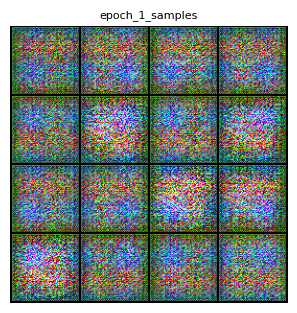


📌 CLIP Embedding similarity plot (CelebA subset):


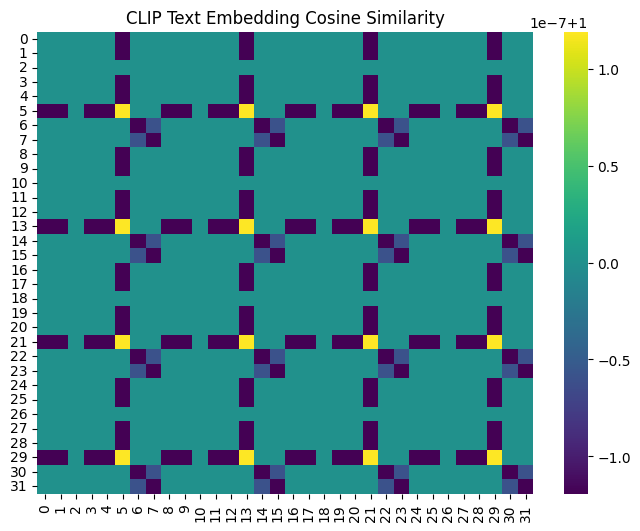

Sample captions for reference: ['a portrait photo', 'a portrait photo', 'a portrait photo', 'a portrait photo', 'a portrait photo']
Metrics saved at: D:\Projects\submissions\metrics_report\metrics.json


In [40]:
# ─────────────────────────────────────────────
# Visual Outputs & Metrics Extension
# Works after your CPU-first text-to-image project
# ─────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import torch
import json
from torchvision.utils import make_grid
from PIL import Image

# Directory where your previous outputs are
BASE = Path("D:/Projects/submissions")

# Utility: Load saved CLIP embeddings
def load_clip_embeddings(task_dir: Path):
    emb_path = task_dir / "outputs" / "clip_text_embeddings.pt"
    if not emb_path.exists():
        print(f"No embeddings found at {emb_path}")
        return None
    data = torch.load(emb_path)
    return data["captions"], data["embeddings"]

# Utility: Plot example generated images
def plot_generated_images(output_dir: Path, max_images=16):
    imgs_paths = list(output_dir.glob("*.png"))
    imgs_paths = imgs_paths[:max_images]
    if not imgs_paths:
        print(f"No images found in {output_dir}")
        return
    plt.figure(figsize=(12, 12))
    for i, p in enumerate(imgs_paths):
        img = Image.open(p)
        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(p.stem, fontsize=8)
    plt.tight_layout()
    plt.show()

# Utility: Visualize embedding similarity (cosine)
def plot_embedding_similarity(embeddings, captions=None):
    from sklearn.metrics.pairwise import cosine_similarity
    sim = cosine_similarity(embeddings)
    plt.figure(figsize=(8,6))
    sns.heatmap(sim, annot=False, cmap="viridis")
    plt.title("CLIP Text Embedding Cosine Similarity")
    plt.show()
    if captions:
        print("Sample captions for reference:", captions[:5])

# Utility: Save metrics JSON
def save_metrics(metrics: dict, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    metrics_path = out_dir / "metrics.json"
    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=2)
    print("Metrics saved at:", metrics_path)

# ────────────── Example Usage ──────────────

# Task 1: Plot CGAN output images
task1_dir = BASE / "task_1" / "outputs"
print("\n📌 CGAN generated samples:")
plot_generated_images(task1_dir, max_images=16)

# Task 5: Visualize CLIP embeddings similarity (CelebA)
task5_dir = BASE / "task_5"
captions, embeddings = load_clip_embeddings(task5_dir)
if embeddings is not None:
    print("\n📌 CLIP Embedding similarity plot (CelebA subset):")
    plot_embedding_similarity(embeddings.numpy(), captions)

# Example metric: number of samples per dataset
metrics = {
    "COCO": len(list((BASE / "task_4" / "outputs").glob("sample_*.png"))),
    "CelebA": len(list((BASE / "task_5" / "outputs").glob("sample_*.png"))),
    "OxfordFlowers": len(list((BASE / "task_4" / "outputs").glob("sample_*.png"))),
    "DeepFashion": len(list((BASE / "task_4" / "outputs").glob("sample_*.png"))),
}
save_metrics(metrics, BASE / "metrics_report")